In [1]:
import numpy as np 
# import pandas as pd
import os
import os.path
import numpy as np
import cv2
# import pandas as pd
import scipy.io
from skimage.transform import resize
import matplotlib.pyplot as plt
import matplotlib.image as imagelib
from tqdm import tqdm
import random
import time
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.backends.cudnn as cudnn
from torch.autograd import Variable
from torch.utils.data.dataset import Dataset
from torchvision import transforms
from torch.utils.data.sampler import SubsetRandomSampler
from tqdm import trange
from time import sleep
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
import zipfile
import torchvision.transforms as transforms
import PIL.Image as Image
from tqdm import tqdm
from torch.autograd import Variable
import torch.nn.functional as F
import torchvision.datasets as datasets
from tqdm import tqdm_notebook

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

print(device)
use_gpu = False
if torch.cuda.is_available():
    device = 'cuda'
    use_gpu = True
else:
    device = 'cpu'
print(use_gpu)
print(torch.cuda.device_count())

cuda:0
True
1


In [2]:
# CIFAR images are 32x32
# We consider a simple 2x2 jigsaw puzzle.
# 0 1
# 3 2
perm_inds = [(0, 0), (48, 0), (48, 48), (0, 48)]
# Simply maps each pixel to [-1, 1]
img_mean = 0.5
img_std = 0.5
    
def permute2x2(images):
    """
    Splits the images into 2x2 = 4 pieces and randomly permutes the pieces.
    """
    p_images = torch.FloatTensor(images.size())
    perms = torch.LongTensor(images.size()[0], 4)
    for i in range(images.size()[0]):
        p = torch.randperm(4)
        for j in range(4):
            sr, sc = perm_inds[j]
            tr, tc = perm_inds[p[j]]
            p_images[i, :, tr:tr+48, tc:tc+48] = images[i, :, sr:sr+48, sc:sc+48]
        perms[i,:] = p
    return(p_images, perms)

def permute2x2_single(images):
    """
    Splits the images into 2x2 = 4 pieces and randomly permutes the pieces.
    """
    p_images = torch.FloatTensor(images.size())
    #perms = torch.LongTensor(4)
    
    p = torch.randperm(4)
    for j in range(4):
        sr, sc = perm_inds[j]
        tr, tc = perm_inds[p[j]]
        p_images[:, tr:tr+48, tc:tc+48] = images[:, sr:sr+48, sc:sc+48]
    return(p_images, p)


def restore2x2(p_images, perms):
    """
    Restores the original image from the pieces and the given permutation.
    """
    images = torch.FloatTensor(p_images.size())
    for i in range(images.size()[0]):
        for j in range(4):
            sr, sc = perm_inds[j]
            tr, tc = perm_inds[perms[i, j]]
            images[i, :, sr:sr+48, sc:sc+48] = p_images[i, :, tr:tr+48, tc:tc+48]
    return images

def perm2vecmat2x2(perms):
    """
    Converts permutation vectors to vectorized assignment matrices.
    """
    n = perms.size()[0]
    mat = torch.zeros(n, 4, 4)
    # m[i][j] : i is assigned to j
    for i in range(n):
        for k in range(4):
            mat[i, k, perms[i, k]] = 1.
    return mat.view(n, -1)

def perm2vecmat2x2_single(perms):
    """
    Converts permutation vectors to vectorized assignment matrices.
    """
    #n = perms.size()[0]
    mat = torch.zeros(4, 4)
    # m[i][j] : i is assigned to j
    for k in range(4):
        mat[k, perms[k]] = 1.
    return mat.view(16)

def vecmat2perm2x2(x):
    """
    Converts vectorized assignment matrices back to permutation vectors.
    Note: this function is compatible with GPU tensors.
    """
    n = x.size()[0]
    x = x.view(n, 4, 4)
    _, ind = x.max(2)
    return ind
    
def imshow(img, title=None):
    """
    Displays a torch image.
    """
    img = img * img_std + img_mean
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    if title != None:
        plt.title(title)
        
def pil_loader(path):
    # open path as file to avoid ResourceWarning (https://github.com/python-pillow/Pillow/issues/835)
    with open(path, 'rb') as f:
        with Image.open(f) as img:
            return img.convert('RGB')

In [3]:
data_transforms = transforms.Compose(
    [transforms.RandomHorizontalFlip(),
     transforms.RandomVerticalFlip(),
     transforms.ToTensor(),
     transforms.Normalize((img_mean, img_mean, img_mean), (img_std, img_std, img_std))])

class STL10DataSet(Dataset):
    def __init__(self, input_images):
        self.images = input_images
        self.num_image = len(self.images)
    
    def __getitem__(self,index):
        img = self.images[index]
        data = data_transforms(pil_loader("Data_Unlabeled/" + img))
        data = data.view(data.size(0), data.size(1), data.size(2))
        data = Variable(data, volatile=True)
        p_image, perm = permute2x2_single(data)
        label = perm2vecmat2x2_single(perm)
        return p_image, perm, label
    
    def __len__(self):
        return self.num_image

/scratch/vp1274/envs/env/lib/python3.6/site-packages/ipykernel_launcher.py:16: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  app.launch_new_instance()


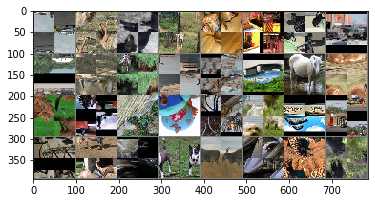

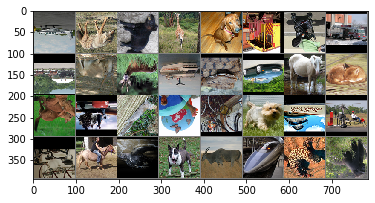

In [4]:
batch_size = 32
dataset_dir = './Data_Unlabeled'

transform = transforms.Compose(
    [transforms.RandomHorizontalFlip(),
     transforms.RandomVerticalFlip(),
     transforms.ToTensor(),
     transforms.Normalize((img_mean, img_mean, img_mean), (img_std, img_std, img_std))])
train_images = os.listdir('Data_Unlabeled')
training_dataset = STL10DataSet(train_images)

#train_set = torchvision.datasets.CIFAR100(root=dataset_dir, train=True, download=True, transform=transform)

# Plot some training samples.
sample_loader = torch.utils.data.DataLoader(training_dataset, batch_size=batch_size,
                                            shuffle=True, num_workers=0)
dataiter = iter(sample_loader)
p_images, perms, labels = next(dataiter)

#p_images, perms = permute2x2(images)

# Check the implementation of per2vecmat and vecmat2perm.
assert(vecmat2perm2x2(perm2vecmat2x2(perms)).equal(perms))

# Show permuted images.
plt.figure()
imshow(torchvision.utils.make_grid(p_images))
# Show restored images.
plt.figure()
imshow(torchvision.utils.make_grid(restore2x2(p_images, perms)))

In [5]:
validation_ratio = 0.1
total = len(training_dataset)
ind = list(range(total))
n_train = int(np.floor((1. - validation_ratio) * total))
n_val = int(np.floor((0.05) * total))
train_ind, validation_ind, test_ind = ind[:n_train], ind[n_train:n_train+n_val], ind[n_train+n_val:]

train_subsampler = torch.utils.data.sampler.SubsetRandomSampler(train_ind)
validation_subsampler = torch.utils.data.sampler.SubsetRandomSampler(validation_ind)
test_subsampler = torch.utils.data.sampler.SubsetRandomSampler(test_ind)

train_loader = torch.utils.data.DataLoader(training_dataset, batch_size=batch_size,
                                           sampler=train_subsampler, num_workers=4)
validation_loader = torch.utils.data.DataLoader(training_dataset, batch_size=batch_size,
                                                sampler=validation_subsampler, num_workers=4)

test_loader = torch.utils.data.DataLoader(training_dataset, batch_size=batch_size,
                                                sampler=test_subsampler, num_workers=4)
print('Number of training batches: {}'.format(len(train_loader)))
print('Number of validation batches: {}'.format(len(validation_loader)))
print('Number of test batches: {}'.format(len(test_loader)))
# test_set = torchvision.datasets.CIFAR100(root=dataset_dir, train=False, download=True, transform=transform)
# test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=0)

Number of training batches: 2813
Number of validation batches: 157
Number of test batches: 157


In [6]:
def sinkhorn(A, n_iter=4):
    """
    Sinkhorn iterations.

    :param A: (n_batches, d, d) tensor
    :param n_iter: Number of iterations.
    """
    for i in range(n_iter):
        A /= A.sum(dim=1, keepdim=True)
        A /= A.sum(dim=2, keepdim=True)
    return A

In [7]:
class SimpleConvNet(nn.Module):
    """
    A simple convolutional neural network shared among all pieces.
    """
    def __init__(self):
        super().__init__()
        # 3 x 48 x 48 input
        self.conv1 = nn.Conv2d(3, 8, 3)
        # 8 x 46 x 46
        self.conv2 = nn.Conv2d(8, 8, 3)
        self.conv2_bn = nn.BatchNorm2d(8)
        # 8 x 44 x 44
        self.pool1 = nn.MaxPool2d(2, 2)
        # 8 x 22 x 22
        self.conv3 = nn.Conv2d(8, 16, 3)
        self.conv3_bn = nn.BatchNorm2d(16)
        # 16 x 20 x 20
        self.conv4 = nn.Conv2d(16, 16, 5)
        self.conv4_bn = nn.BatchNorm2d(16)
        # 16 x 16 x 16
        self.pool2 = nn.MaxPool2d(2, 2)
        # 16 x 8 x 8
        
        self.fc1 = nn.Linear(16 * 20 * 20, 400)
        self.fc1_bn = nn.BatchNorm1d(400)
        # 128-d features
        self.fc2 = nn.Linear(400, 128)
        self.fc2_bn = nn.BatchNorm1d(128)
    
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2_bn(self.conv2(x)))
        x = self.pool1(x)
        x = F.relu(self.conv3_bn(self.conv3(x)))
        #x = F.relu(self.conv4_bn(self.conv4(x)))
        #x = self.pool2(x)
        x = x.view(-1, 16 * 20 * 20)
        x = F.relu(self.fc1_bn(self.fc1(x)))
        x = F.relu(self.fc2_bn(self.fc2(x)))
        return x

class JigsawNet(nn.Module):
    """
    A neural network that solves 2x2 jigsaw puzzles.
    """
    def __init__(self, sinkhorn_iter=0):
        super().__init__()
        self.conv_net = SimpleConvNet()
        self.fc1 = nn.Linear(128 * 4, 256)
        self.fc1_bn = nn.BatchNorm1d(256)
        # 4 x 4 assigment matrix
        self.fc2 = nn.Linear(256, 16)
        self.sinkhorn_iter = sinkhorn_iter
    
    def forward(self, x):
        # Split input into four pieces and pass them into the
        # same convolutional neural network.
        x0 = self.conv_net(x[:, :, 0:48, 0:48])
        x1 = self.conv_net(x[:, :, 48:96, 0:48])
        x2 = self.conv_net(x[:, :, 48:96, 48:96])
        x3 = self.conv_net(x[:, :, 0:48, 48:96])
        # Cat
        x = torch.cat([x0, x1, x2, x3], dim=1)
        # Dense layer
        x = F.dropout(x, p=0.1, training=self.training)
        x = F.relu(self.fc1_bn(self.fc1(x)))
        x = F.sigmoid(self.fc2(x))
#         if self.sinkhorn_iter > 0:
#             x = x.view(-1, 4, 4)
#             x = sinkhorn(x, self.sinkhorn_iter)
#             x = x.view(-1, 16)
        return x

In [8]:
# Test helper
def compute_acc(p_pred, p_true, average=True):
    """
    We require that the location of all four pieces are correctly predicted.
    Note: this function is compatible with GPU tensors.
    """
    # Remember to cast to float.
    n = torch.sum((torch.sum(p_pred == p_true, 1) == 4).float())
    if average:
        return n / p_pred.size()[0]
    else:
        return n

# Training process
def train_model(model, criterion, optimizer, train_loader, validation_loader,
                n_epochs=40, save_file_name=None):
    loss_history = []
    val_loss_history = []
    acc_history = []
    val_acc_history = []
    for epoch in range(n_epochs):
        with tqdm_notebook(total=len(train_loader), desc="Epoch {}".format(epoch + 1), unit='b', leave=False) as pbar:
            # Training phase
            model.train()
            running_loss = 0.
            n_correct_pred = 0
            n_samples = 0
            for i, data in enumerate(train_loader, 0):
                with torch.autograd.set_detect_anomaly(True):
                    #inputs, _ = data
                    x_in, perms, y_in =data 
                    #x_in, perms = permute2x2(inputs)
                    #y_in = perm2vecmat2x2(perms)
                    n_samples += x_in.size()[0]
                    if is_cuda_available:
                        x_in, y_in = x_in.cuda(), y_in.cuda()
                        perms = perms.cuda()
                    else:
                        x_in, y_in = Variable(x_in), Variable(y_in)
                        perms = Variable(perms)
                    optimizer.zero_grad()
                    outputs = model(x_in)
                    n_correct_pred += compute_acc(vecmat2perm2x2(outputs), perms, False).item()
                    loss = criterion(outputs, y_in)
                    loss.backward()
                    optimizer.step()
                    running_loss += loss.item() * x_in.size()[0]
                pbar.update(1)
            loss_history.append(running_loss / n_samples)
            acc_history.append(n_correct_pred / n_samples)
            
            # Validation phase
            model.eval()
            running_loss = 0.
            n_correct_pred = 0
            n_samples = 0
            for i, data in enumerate(validation_loader, 0):
                #inputs, _ = data
                x_in, perms, y_in =data 
                #x_in, perms = permute2x2(inputs)
                #y_in = perm2vecmat2x2(perms)
                n_samples += x_in.size()[0]
                if is_cuda_available:
                    #x_in, y_in = Variable(x_in.cuda()), Variable(y_in.cuda())
                    x_in, y_in = x_in.cuda(), y_in.cuda()
                    perms = perms.cuda()
                else:
                    x_in, y_in = Variable(x_in), Variable(y_in)
                    perms = Variable(perms)
                outputs = model(x_in)
                n_correct_pred += compute_acc(vecmat2perm2x2(outputs), perms, False).item()
                loss = criterion(outputs, y_in)
                running_loss += loss.item() * x_in.size()[0]
            val_loss_history.append(running_loss / n_samples)
            val_acc_history.append(n_correct_pred / n_samples)
            
            # Update the progress bar.
            print("Epoch {0:03d}: loss={1:.4f}, val_loss={2:.4f}, acc={3:.2%}, val_acc={4:.2%}".format(
                epoch + 1, loss_history[-1], val_loss_history[-1], acc_history[-1], val_acc_history[-1]))
    print('Training completed')
    history = {
        'loss': loss_history,
        'val_loss': val_loss_history,
        'acc': acc_history,
        'val_acc': val_acc_history
    }
    # Save the model when requested.
    if save_file_name is not None:
        torch.save({
            'history': history,
            'model': model.state_dict(),
            'optimizer': optimizer.state_dict()
        }, save_file_name)
    return history

# Test process
# Compute the accuracy
def test_model(model, test_loader):
    running_acc = 0.
    n = 0
    model.eval()
    for i, data in enumerate(test_loader, 0):
        inputs, _ = data
        x_in, perms = permute2x2(inputs)
        y_in = perm2vecmat2x2(perms)
        if is_cuda_available:
            x_in, y_in = Variable(x_in.cuda()), Variable(y_in.cuda())
        else:
            x_in, y_in = Variable(x_in), Variable(y_in)
        pred = model(x_in)
        perms_pred = vecmat2perm2x2(pred.cpu().data)
        running_acc += compute_acc(perms_pred, perms, False)
        n += x_in.size()[0]
    acc = running_acc / n
    return acc

In [9]:
n_epochs = 40
sinkhorn_iter = 5

# Create the neural network.
model = JigsawNet(sinkhorn_iter=sinkhorn_iter)
is_cuda_available = torch.cuda.is_available();
if is_cuda_available:
    model.cuda()

n_params = 0
for p in model.parameters():
    n_params += np.prod(p.size())
print('# of parameters: {}'.format(n_params))

# We use binary cross-entropy loss here.
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters())

# Train
save_file_name = 'jigsaw_stl10_e{}_s{}.pth'.format(n_epochs, sinkhorn_iter)
history = train_model(model, criterion, optimizer, train_loader, validation_loader,
                      n_epochs=n_epochs, save_file_name=save_file_name)

# of parameters: 2757208


/scratch/vp1274/envs/env/lib/python3.6/site-packages/ipykernel_launcher.py:22: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


/scratch/vp1274/envs/env/lib/python3.6/site-packages/ipykernel_launcher.py:16: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  app.launch_new_instance()
/scratch/vp1274/envs/env/lib/python3.6/site-packages/torch/nn/functional.py:1351: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch 001: loss=0.3411, val_loss=0.2696, acc=41.09%, val_acc=55.52%


Epoch 002: loss=0.2750, val_loss=0.2434, acc=54.35%, val_acc=59.98%


Epoch 003: loss=0.2530, val_loss=0.2322, acc=58.23%, val_acc=61.72%


Epoch 004: loss=0.2404, val_loss=0.2243, acc=60.31%, val_acc=63.40%


Epoch 005: loss=0.2294, val_loss=0.2117, acc=62.03%, val_acc=65.44%


Epoch 006: loss=0.2199, val_loss=0.2077, acc=63.71%, val_acc=66.82%


Epoch 007: loss=0.2113, val_loss=0.1962, acc=65.16%, val_acc=68.62%


Epoch 008: loss=0.2032, val_loss=0.1912, acc=66.70%, val_acc=69.80%


Epoch 009: loss=0.1939, val_loss=0.1826, acc=68.28%, val_acc=71.60%


Epoch 010: loss=0.1871, val_loss=0.1760, acc=69.45%, val_acc=71.82%


Epoch 011: loss=0.1808, val_loss=0.1778, acc=70.50%, val_acc=72.16%


Epoch 012: loss=0.1747, val_loss=0.1691, acc=71.71%, val_acc=73.24%


Epoch 013: loss=0.1701, val_loss=0.1651, acc=72.37%, val_acc=74.04%


Epoch 014: loss=0.1649, val_loss=0.1586, acc=73.19%, val_acc=74.82%


Epoch 015: loss=0.1607, val_loss=0.1602, acc=73.84%, val_acc=74.68%


Epoch 016: loss=0.1562, val_loss=0.1593, acc=74.60%, val_acc=74.86%


Epoch 017: loss=0.1537, val_loss=0.1555, acc=74.93%, val_acc=75.40%


Epoch 018: loss=0.1490, val_loss=0.1563, acc=75.72%, val_acc=75.66%


Epoch 019: loss=0.1459, val_loss=0.1526, acc=76.19%, val_acc=75.86%


Epoch 020: loss=0.1432, val_loss=0.1522, acc=76.72%, val_acc=76.00%


Epoch 021: loss=0.1393, val_loss=0.1494, acc=77.30%, val_acc=76.24%


Epoch 022: loss=0.1364, val_loss=0.1512, acc=77.76%, val_acc=76.10%


Epoch 023: loss=0.1335, val_loss=0.1473, acc=78.28%, val_acc=76.78%


Epoch 024: loss=0.1317, val_loss=0.1515, acc=78.62%, val_acc=76.46%


Epoch 025: loss=0.1290, val_loss=0.1476, acc=78.99%, val_acc=76.72%


Epoch 026: loss=0.1262, val_loss=0.1509, acc=79.41%, val_acc=75.98%


Epoch 027: loss=0.1237, val_loss=0.1486, acc=79.96%, val_acc=76.84%


Epoch 028: loss=0.1212, val_loss=0.1474, acc=80.35%, val_acc=77.24%


Epoch 029: loss=0.1190, val_loss=0.1508, acc=80.67%, val_acc=76.42%


Epoch 030: loss=0.1166, val_loss=0.1451, acc=81.02%, val_acc=77.66%


Epoch 031: loss=0.1148, val_loss=0.1539, acc=81.37%, val_acc=76.08%


Epoch 032: loss=0.1127, val_loss=0.1507, acc=81.63%, val_acc=77.24%


Epoch 033: loss=0.1100, val_loss=0.1530, acc=82.04%, val_acc=76.76%


Epoch 034: loss=0.1090, val_loss=0.1472, acc=82.23%, val_acc=77.60%


Epoch 035: loss=0.1070, val_loss=0.1500, acc=82.67%, val_acc=77.46%


Epoch 036: loss=0.1054, val_loss=0.1439, acc=82.98%, val_acc=77.62%


Epoch 037: loss=0.1030, val_loss=0.1488, acc=83.27%, val_acc=76.60%


Epoch 038: loss=0.1014, val_loss=0.1596, acc=83.37%, val_acc=76.14%


Epoch 039: loss=0.0988, val_loss=0.1532, acc=83.90%, val_acc=76.86%


Epoch 040: loss=0.0988, val_loss=0.1561, acc=84.07%, val_acc=76.98%
Training completed
